# TC_Debbie_land_cover_classification

Based on the notebook "AA_photosynthetic_vegetation_median_Mackay_example.ipynb" by Leo Lymburner.

Written by Claire Krause, May 2017

**Five AGDC datasets used in this classification**
* surface reflectance (Landsat bands: red, green, blue, nir, swir1, swir2)
* surface reflectance, visible bands only (Landsat bands: red, green, blue)
* fractional cover - photosynthetic vegetation
* fractional cover - bare soil
* slope (derived from elevation)

**Analysis time and extents**
* time: '2015-01-01', '2015-05-01' - chosen as the approximate season prior to TC Debbie. Note that a change in the time period chosen will likely affect the classification scheme.
* extent: 'lat': (-19.9, -20.97), 'lon': (147.97, 149.55)

**Output categories**
1. Forest -> 774
2. Urban -> 806
3. Open forest -> 898
4. Crops/grassland -> 949
5. Water -> 1000
6. Bare ground -> 1063

**Workflow**
1. Each of the four datasets are read in separately to save memory. 
2. Bands are processed to generate surface reflectance and slope
3. A time mean is created for the whole time extent
4. Processed data are pickled and written out
5. Once all the data are processed, the four picked datasets are read back into memory
6. Each dataset is plotted with a categorical colour bar, and a histogram is created to show the spread of the data values to allow classification process to begin
7. Classification is based on selected thresholds across the four datasets. This is based on subjective classification by the user. Values are tweaked to best differentiate known landscape features. Note that 'open forest' is used as a default category
8. Classified Dataframe is written out to GeoTiff

# Start the analysis with fractional cover - photosynthetic vegetation (PV)

In [1]:
#Imports
%pylab notebook
#%matplotlib inline
import ipywidgets as widgets
from datacube.helpers import ga_pq_fuser
from matplotlib import pyplot as plt
import numpy as np
import datacube
import xarray as xr
from datacube.utils import geometry
from datacube.api import make_mask
import pickle, gzip
import folium
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [3]:
# Function to load and mask Fractional Cover
def load_multiple_masked_fc(platforms, query, bands):
    datasets = []
    for platform in platforms:
        product_name = '{}_{}_albers'.format(platform, 'fc')
        print ('Loading product: {}'.format(product_name))
        # Load NBAR
        ds = dc.load(product=product_name, measurements=bands, group_by='solar_day', **query)
        print('Loaded: {}'.format(product_name))
        crs = ds.crs
        affine = ds.affine
        # Load PQ Mask
        mask_product = '{}_{}_albers'.format(platform, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser, group_by='solar_day', **query)
        print('Loaded: {}'.format(mask_product))
        cloud_free = make_mask(sensor_pq.pixelquality, **mask_components)
        #cloud_free = make_mask(sensor_pq.pixelquality, ga_good_pixel=True)
        print('Made cloud mask')
        ds = ds.where(cloud_free) #.fillna(-999).astype('int16')
        print('Masked out clouds')
        ds['product'] = ('time', np.repeat(product_name, ds.time.size))
        datasets.append(ds)

    combined = xr.concat(datasets, dim='time')
    combined = combined.isel(time=combined.time.argsort())  # sort along time dim
    return combined

## Read in and process PV

In [4]:
%%time
dc = datacube.Datacube(app='FC-App')#, config=dbconfig)

bands_of_interest = ['PV']
platforms = ['ls8']
query = {
    'time': ('2015-01-01', '2015-05-01'), # Summer/approximate season of TC Debbie
     'lat': (-19.9, -20.97),
     'lon': (147.97, 149.55),
    'resolution': (25, 25),
        }
fcDrill = load_multiple_masked_fc(platforms, query, bands_of_interest)
print(fcDrill)

Loading product: ls8_fc_albers
Loaded: ls8_fc_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
<xarray.Dataset>
Dimensions:  (time: 21, x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
  * time     (time) datetime64[ns] 2015-01-08T00:04:53.500000 ...
Data variables:
    PV       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    product  (time) <U13 'ls8_fc_albers' 'ls8_fc_albers' 'ls8_fc_albers' ...
Attributes:
    crs:      EPSG:3577
CPU times: user 48 s, sys: 22.1 s, total: 1min 10s
Wall time: 1min 11s


In [5]:
all_mean = fcDrill.min(dim='time', keep_attrs=True)
all_mean

<xarray.Dataset>
Dimensions:  (x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
Data variables:
    PV       (y, x) float64 36.0 42.0 43.0 45.0 47.0 46.0 42.0 44.0 40.0 ...
    product  <U13 'ls8_fc_albers'
Attributes:
    crs:      EPSG:3577

### Write out the final PV array to save memory

In [6]:
# Save the file
with gzip.open('/g/data/w85/sj9724/PV.sav', 'wb') as f:
        pickle.dump(all_mean, f,-1)

# Clear everything in memory and start again with bare soil

Note that this command clear EVERYTHING, so need to reload modules

In [7]:
%reset -f

In [8]:
#Imports
%pylab notebook
#%matplotlib inline
import ipywidgets as widgets
from datacube.helpers import ga_pq_fuser
from matplotlib import pyplot as plt
import numpy as np
import datacube
import xarray as xr
from datacube.utils import geometry
from datacube.api import make_mask
import pickle, gzip
import folium
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [9]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [10]:
# Function to load and mask Fractional Cover
def load_multiple_masked_fc(platforms, query, bands):
    datasets = []
    for platform in platforms:
        product_name = '{}_{}_albers'.format(platform, 'fc')
        print ('Loading product: {}'.format(product_name))
        # Load NBAR
        ds = dc.load(product=product_name, measurements=bands, group_by='solar_day', **query)
        print('Loaded: {}'.format(product_name))
        crs = ds.crs
        affine = ds.affine
        # Load PQ Mask
        mask_product = '{}_{}_albers'.format(platform, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser, group_by='solar_day', **query)
        print('Loaded: {}'.format(mask_product))
        cloud_free = make_mask(sensor_pq.pixelquality, **mask_components)
        #cloud_free = make_mask(sensor_pq.pixelquality, ga_good_pixel=True)
        print('Made cloud mask')
        ds = ds.where(cloud_free) #.fillna(-999).astype('int16')
        print('Masked out clouds')
        ds['product'] = ('time', np.repeat(product_name, ds.time.size))
        datasets.append(ds)

    combined = xr.concat(datasets, dim='time')
    combined = combined.isel(time=combined.time.argsort())  # sort along time dim
    return combined

## Read in and process bare soil

In [11]:
%%time
dc = datacube.Datacube(app='FC-App')#, config=dbconfig)

bands_of_interest = ['BS']
platforms = ['ls8']
query = {
    'time': ('2015-01-01', '2015-05-01'), # Summer/approximate season of TC Debbie
     'lat': (-19.9, -20.97),
     'lon': (147.97, 149.55),
    'resolution': (25, 25),
        }
fcDrill = load_multiple_masked_fc(platforms, query, bands_of_interest)
print(fcDrill)

Loading product: ls8_fc_albers
Loaded: ls8_fc_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
<xarray.Dataset>
Dimensions:  (time: 21, x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
  * time     (time) datetime64[ns] 2015-01-08T00:04:53.500000 ...
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    product  (time) <U13 'ls8_fc_albers' 'ls8_fc_albers' 'ls8_fc_albers' ...
Attributes:
    crs:      EPSG:3577
CPU times: user 48.6 s, sys: 20.7 s, total: 1min 9s
Wall time: 1min 14s


In [12]:
all_mean = fcDrill.min(dim='time', keep_attrs=True)
all_mean

<xarray.Dataset>
Dimensions:  (x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
Data variables:
    BS       (y, x) float64 0.0 2.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 3.0 8.0 5.0 ...
    product  <U13 'ls8_fc_albers'
Attributes:
    crs:      EPSG:3577

## Write out the final BS array to save memory

In [13]:
# Save the file
with gzip.open('/g/data/w85/sj9724/BS.sav', 'wb') as f:
        pickle.dump(all_mean, f,-1)

# Clear everything in memory and start again with surface reflectance - all bands

Note that this command clear EVERYTHING, so need to reload modules

In [14]:
%reset -f

In [15]:
#Imports
%pylab notebook
#%matplotlib inline
import ipywidgets as widgets
from datacube.helpers import ga_pq_fuser
from matplotlib import pyplot as plt
import numpy as np
import datacube
import xarray as xr
from datacube.utils import geometry
from datacube.api import make_mask
import pickle, gzip
import folium
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [16]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [17]:
# Function to load, mask and process data
def load_multiple_masked_fc(platforms, query, bands):
    for platform in platforms:
        for band in bands:
            product_name = '{}_{}_albers'.format(platform, 'nbar')
            print ('Loading product: {}'.format(product_name))
            # Load NBAR
            ds = dc.load(product=product_name, measurements=[band], group_by='solar_day', **query)
            print('Loaded: {}'.format(product_name))
            crs = ds.crs
            affine = ds.affine
            # Load PQ Mask
            mask_product = '{}_{}_albers'.format(platform, 'pq')
            sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser, group_by='solar_day', **query)
            print('Loaded: {}'.format(mask_product))
            cloud_free = make_mask(sensor_pq.pixelquality, **mask_components)
            #cloud_free = make_mask(sensor_pq.pixelquality, ga_good_pixel=True)
            print('Made cloud mask')
            ds = ds.where(cloud_free) #.fillna(-999).astype('int16')\
            print('Masked out clouds')
            # Make just an average value for all time
            ds = ds.mean(dim = 'time')        
            try:
                datasets
            except:
                datasets = ds
            else:
                datasets = xr.merge([datasets, ds])
    print (datasets)
    return datasets

## Read in and process all band reflectance

In [18]:
%%time
dc = datacube.Datacube(app='FC-App')#, config=dbconfig)

bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1',
                     'swir2']

platforms = ['ls8']
query = {
        'time': ('2015-01-01', '2015-05-01'), # Summer/approximate season of TC Debbie
        'lat': (-19.9, -20.97),
        'lon': (147.97, 149.55),
        'resolution': (25, 25)
        }
fcDrill = load_multiple_masked_fc(platforms, query, bands_of_interest)
print(fcDrill)

Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
<xarray.Dataset>
Dimensions:  (x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
Data variables:
    blue     (y, x) float64 526.2 469.7 482.0 476.4 474.6 461.6 461.7 459.4 ...
    green   

In [19]:
add_together = fcDrill.red + fcDrill.blue + fcDrill.green + fcDrill.nir + fcDrill.swir1 + fcDrill.swir2
add_together = add_together.to_dataset(name = 'reflectance')

## Write out the final all band surface reflectance array to save memory

In [20]:
# Save the file
with gzip.open('/g/data/w85/sj9724/add_all_bands.sav', 'wb') as f:
        pickle.dump(add_together, f,-1)

# Clear everything in memory and start again with surface reflectance - visible only

Note that this command clear EVERYTHING, so need to reload modules

In [21]:
%reset -f

In [22]:
#Imports
%pylab notebook
#%matplotlib inline
import ipywidgets as widgets
from datacube.helpers import ga_pq_fuser
from matplotlib import pyplot as plt
import numpy as np
import datacube
import xarray as xr
from datacube.utils import geometry
from datacube.api import make_mask
import pickle, gzip
import folium
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [23]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [24]:
# Function to load, mask and process data
def load_multiple_masked_fc(platforms, query, bands):
    for platform in platforms:
        for band in bands:
            product_name = '{}_{}_albers'.format(platform, 'nbar')
            print ('Loading product: {}'.format(product_name))
            # Load NBAR
            ds = dc.load(product=product_name, measurements=[band], group_by='solar_day', **query)
            print('Loaded: {}'.format(product_name))
            crs = ds.crs
            affine = ds.affine
            # Load PQ Mask
            mask_product = '{}_{}_albers'.format(platform, 'pq')
            sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser, group_by='solar_day', **query)
            print('Loaded: {}'.format(mask_product))
            cloud_free = make_mask(sensor_pq.pixelquality, **mask_components)
            #cloud_free = make_mask(sensor_pq.pixelquality, ga_good_pixel=True)
            print('Made cloud mask')
            ds = ds.where(cloud_free) #.fillna(-999).astype('int16')\
            print('Masked out clouds')
            # Make just an average value for all time
            ds = ds.mean(dim = 'time')        
            try:
                datasets
            except:
                datasets = ds
            else:
                datasets = xr.merge([datasets, ds])
    print (datasets)
    return datasets

## Read in and process visible bands

In [25]:
%%time
dc = datacube.Datacube(app='FC-App')#, config=dbconfig)

bands_of_interest = ['blue',
                     'green',
                     'red']

platforms = ['ls8']
query = {
        'time': ('2015-01-01', '2015-05-01'), # Summer/approximate season of TC Debbie
        'lat': (-19.9, -20.97),
        'lon': (147.97, 149.55),
        'resolution': (25, 25)
        }
fcDrill = load_multiple_masked_fc(platforms, query, bands_of_interest)
print(fcDrill)

Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
Loading product: ls8_nbar_albers
Loaded: ls8_nbar_albers
Loaded: ls8_pq_albers
Made cloud mask
Masked out clouds
<xarray.Dataset>
Dimensions:  (x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
Data variables:
    blue     (y, x) float64 526.2 469.7 482.0 476.4 474.6 461.6 461.7 459.4 ...
    green    (y, x) float64 744.0 694.9 720.9 708.4 698.7 684.9 690.3 674.9 ...
    red      (y, x) float64 792.8 771.4 814.6 795.4 779.1 763.7 767.9 747.3 ...
<xarray.Dataset>
Dimensions:  (x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1

In [26]:
add_together = fcDrill.red + fcDrill.blue + fcDrill.green
add_together = add_together.to_dataset(name = 'reflectance_vis')

## Write out the final visible band surface reflectance array to save memory

In [27]:
# Save the file
with gzip.open('/g/data/w85/sj9724/add_vis_bands.sav', 'wb') as f:
        pickle.dump(add_together, f,-1)

# Clear everything in memory and start again with elevation

Note that this command clear EVERYTHING, so need to reload modules

In [28]:
%reset -f

In [1]:
#Imports
%pylab notebook
import ipywidgets as widgets
from datacube.helpers import ga_pq_fuser
from matplotlib import pyplot as plt
import numpy as np
import datacube
import xarray as xr
from datacube.utils import geometry
from datacube.api import make_mask
import pickle, gzip
import folium
from IPython.display import display
import scipy.ndimage

Populating the interactive namespace from numpy and matplotlib


## Read in and process elevation

In [49]:
%%time
dc = datacube.Datacube(app='FC-App')#, config=dbconfig)

query = {'lat': (-19.9, -20.97),
         'lon': (147.97, 149.55),
         'output_crs': 'EPSG:3577', 
         'resolution': (-25, 25)
        }

elev = dc.load(product = 'srtm_dem1sv1_0', group_by='solar_day', **query)
print (elev)

<xarray.Dataset>
Dimensions:  (time: 1, x: 7127, y: 5582)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-15T14:58:44
  * y        (y) float64 -2.237e+06 -2.237e+06 -2.237e+06 -2.237e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
Data variables:
    dem      (time, y, x) float32 19.0 19.0 18.0 18.0 18.0 17.0 18.0 17.0 ...
    dem_s    (time, y, x) float32 18.3829 18.2701 18.1305 18.1305 18.0255 ...
    dem_h    (time, y, x) float32 18.3604 18.2872 18.1555 18.1555 18.0345 ...
Attributes:
    crs:      EPSG:3577
CPU times: user 5.69 s, sys: 2.59 s, total: 8.28 s
Wall time: 6.24 s


In [32]:
x, y = np.gradient(elev.dem_s, axis=(0,1))
ns = abs(np.pi/2. - np.arctan(x))
ew = (np.pi/2. - np.arctan(y))
slope = np.maximum(ns, ew)
slope

array([[ 1.68309009,  1.69632125,  1.64048755, ...,  1.57079637,
         1.57079637,  1.57079637],
       [ 1.78975892,  1.76846683,  1.85516727, ...,  1.57079637,
         1.57079637,  1.57079637],
       [ 2.17766333,  1.98207593,  1.68001449, ...,  1.57079637,
         1.57079637,  1.57079637],
       ..., 
       [ 1.00666416,  1.32505667,  1.3369782 , ...,  1.57079637,
         1.57079637,  1.57079637],
       [ 1.57079637,  1.43001032,  1.45920134, ...,  1.57079637,
         1.57079637,  1.57079637],
       [ 1.57079637,  1.32225931,  1.53562415, ...,  1.57079637,
         1.57079637,  1.57079637]], dtype=float32)

In [33]:
slope = xr.DataArray(slope, coords = {'y': elev.y, 'x': elev.x})
slope = slope.to_dataset(name = 'slope')
slope

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: inferring DataArray dimensions from dictionary like ``coords`` has been deprecated. Use an explicit list of ``dims`` instead.
  """Entry point for launching an IPython kernel.


<xarray.Dataset>
Dimensions:  (x: 7127, y: 5582)
Coordinates:
  * y        (y) float64 -2.237e+06 -2.237e+06 -2.237e+06 -2.237e+06 ...
  * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
Data variables:
    slope    (y, x) float32 1.68309 1.69632 1.64049 1.67548 1.80813 1.75916 ...

## Write out the final slope array to save memory

In [34]:
# Save the file
with gzip.open('/g/data/w85/sj9724/slope.sav', 'wb') as f:
        pickle.dump(slope, f,-1)

# Pull all our datasets back in for classification

In [35]:
%reset -f

In [1]:
#Imports
%pylab notebook
import ipywidgets as widgets
from datacube.helpers import ga_pq_fuser
from matplotlib import pyplot as plt
import numpy as np
import datacube
import xarray as xr
from datacube.utils import geometry
from datacube.api import make_mask
import pickle, gzip
import folium
from IPython.display import display
import scipy.ndimage
import netCDF4
from osgeo.osr import SpatialReference

Populating the interactive namespace from numpy and matplotlib


In [2]:
PV_file = gzip.open('/g/data/w85/sj9724/PV.sav', 'rb')
PV = pickle.load(PV_file)

BS_file = gzip.open('/g/data/w85/sj9724/BS.sav', 'rb')
BS = pickle.load(BS_file)

albedo_file = gzip.open('/g/data/w85/sj9724/add_all_bands.sav', 'rb')
albedo = pickle.load(albedo_file)

vis_file = gzip.open('/g/data/w85/sj9724/add_vis_bands.sav', 'rb')
visible = pickle.load(vis_file)

slope_file = gzip.open('/g/data/w85/sj9724/slope.sav', 'rb')
slope = pickle.load(slope_file)

In [38]:
albedo, PV, slope, BS, visible

(<xarray.Dataset>
 Dimensions:      (x: 7127, y: 5582)
 Coordinates:
   * y            (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
   * x            (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
 Data variables:
     reflectance  (y, x) float64 8.449e+03 8.578e+03 8.925e+03 8.74e+03 ...,
 <xarray.Dataset>
 Dimensions:  (x: 7127, y: 5582)
 Coordinates:
   * y        (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
   * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
 Data variables:
     PV       (y, x) float64 36.0 42.0 43.0 45.0 47.0 46.0 42.0 44.0 40.0 ...
     product  <U13 'ls8_fc_albers'
 Attributes:
     crs:      EPSG:3577,
 <xarray.Dataset>
 Dimensions:  (x: 7127, y: 5582)
 Coordinates:
   * y        (y) float64 -2.237e+06 -2.237e+06 -2.237e+06 -2.237e+06 ...
   * x        (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
 Data variables:
     slope    (y, x) float32 1.68309 1.69632 1.64049 1.67548 

# Plot up data to begin to determine cut off values

These plots are used to develop the classification scheme. Categorical colourbars are used to help determine suitable cut offs for different land surface types. The colour bars can be changed to examine possible cut off values across the whole data range, or within just one small part (if you are trying to determine the best cut off point between categories). 

## Fractional cover - photosynthetic vegetation (PV)

<IPython.core.display.Javascript object>


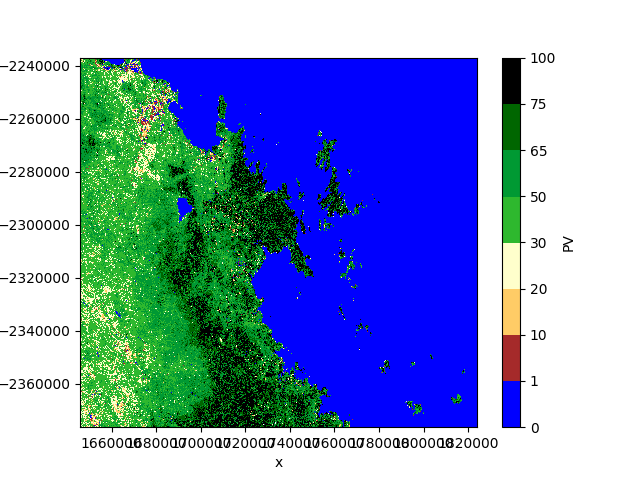

<IPython.core.display.Javascript object>


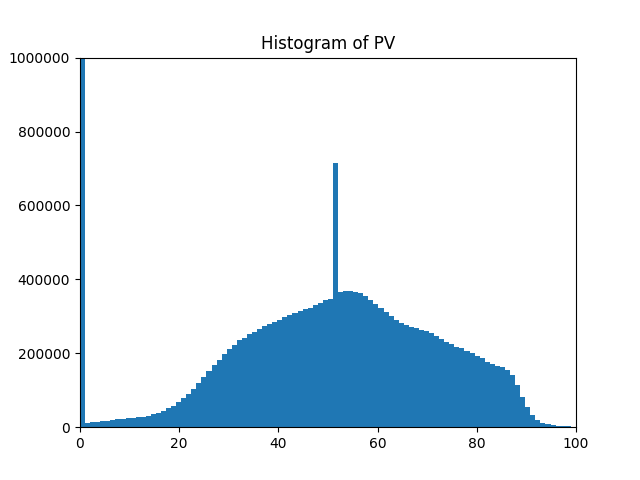

(0, 1000000)

In [39]:
pv_cmap = mpl.colors.ListedColormap(['blue', 'brown', '#ffcc66','#ffffcc'  , '#2eb82e', '#009933' , '#006600', 'black'])
pv_bounds = [0,1, 10, 20, 30, 50, 65, 75, 100]
pv_norm = mpl.colors.BoundaryNorm(pv_bounds, pv_cmap.N)

fig = plt.figure()
PV.PV.plot.imshow(cmap = pv_cmap, norm = pv_norm, vmin = 0, vmax = 25000)

fig = plt.figure()
PV.PV.plot.hist(bins = 100)
plt.xlim([0,100])
plt.ylim([0, 1000000])

## Fractional cover - bare soil (BS)

<IPython.core.display.Javascript object>


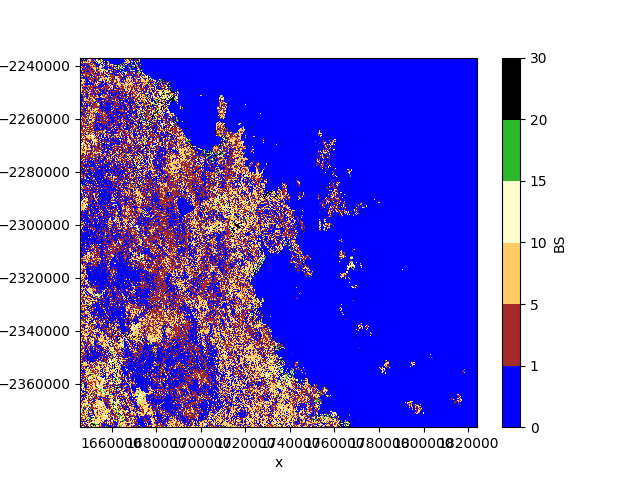

<IPython.core.display.Javascript object>


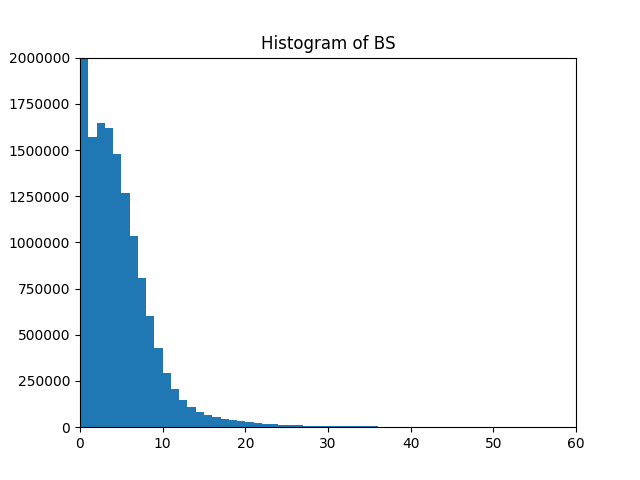

(0, 2000000)

In [40]:
pv_cmap = mpl.colors.ListedColormap(['blue', 'brown', '#ffcc66','#ffffcc'  , '#2eb82e', '#009933' ,'black'])
pv_bounds = [0, 1, 5, 10, 15, 20, 30]
pv_norm = mpl.colors.BoundaryNorm(pv_bounds, pv_cmap.N)

fig = plt.figure()
BS.BS.plot.imshow(cmap = pv_cmap, norm = pv_norm, vmin = 0, vmax = 25000)

fig = plt.figure()
BS.BS.plot.hist(bins = 100)
plt.xlim([0,60])
plt.ylim([0, 2000000])

## Surface reflectance

<IPython.core.display.Javascript object>


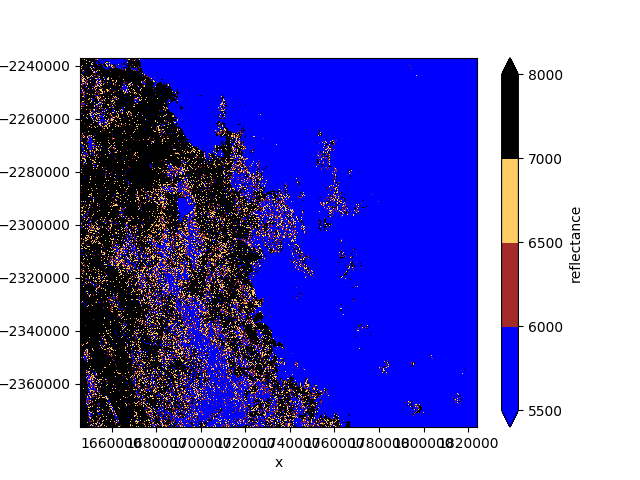

<IPython.core.display.Javascript object>


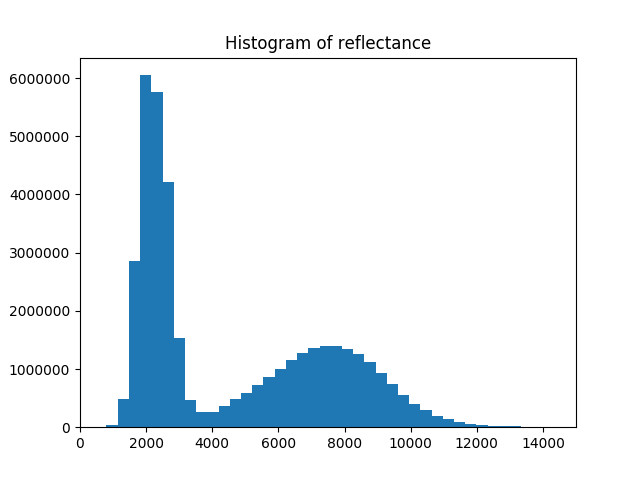

(0, 15000)

In [41]:
pv_cmap = mpl.colors.ListedColormap(['blue', 'brown', 'cyan', '#ffcc66', '#ffffcc', 'black'])
pv_bounds = [5500, 6000, 6500, 7000, 8000]
pv_norm = mpl.colors.BoundaryNorm(pv_bounds, pv_cmap.N)

fig = plt.figure()
albedo.reflectance.plot.imshow(cmap = pv_cmap, vmin = 6000, vmax = 8000, norm = pv_norm) 

fig = plt.figure()
albedo.reflectance.plot.hist(bins = 100)
plt.xlim([0,15000])

## Surface reflectance - visible

<IPython.core.display.Javascript object>


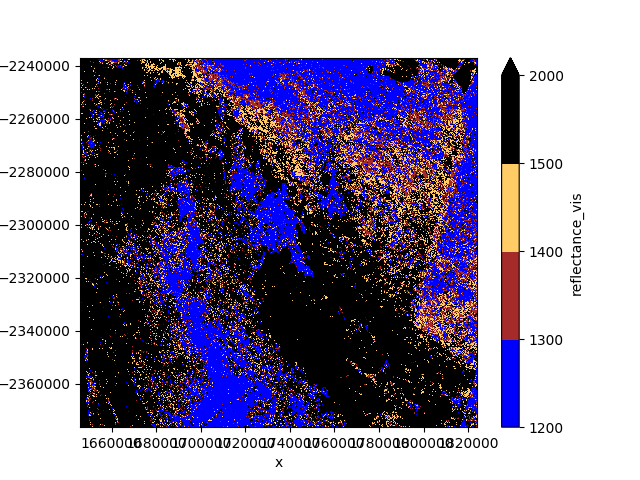

<IPython.core.display.Javascript object>


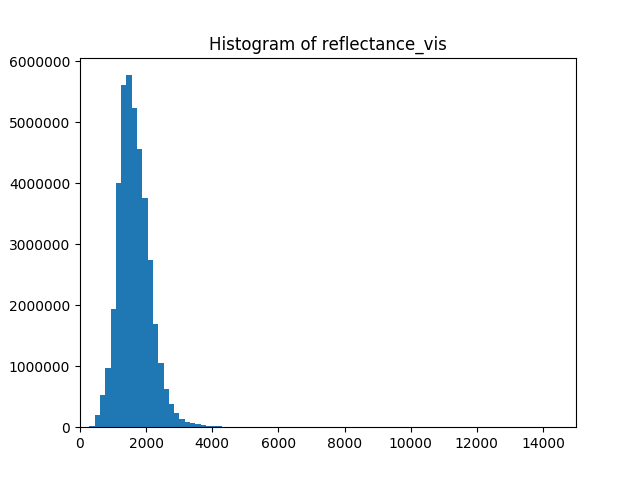

(0, 15000)

In [42]:
pv_cmap = mpl.colors.ListedColormap(['blue', 'brown', 'cyan', '#ffcc66', '#ffffcc', 'black'])
pv_bounds = [1200, 1300, 1400, 1500, 2000]
pv_norm = mpl.colors.BoundaryNorm(pv_bounds, pv_cmap.N)

fig = plt.figure()
visible.reflectance_vis.plot.imshow(cmap = pv_cmap, vmin = 0, vmax = 2000, norm = pv_norm) 

fig = plt.figure()
visible.reflectance_vis.plot.hist(bins = 100)
plt.xlim([0,15000])

## Slope

<IPython.core.display.Javascript object>


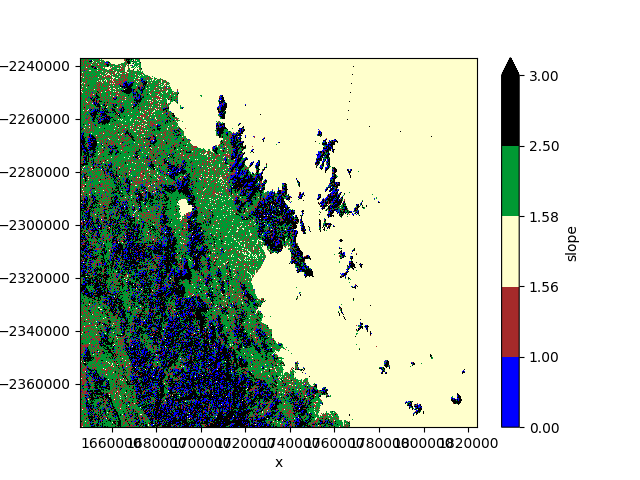

<IPython.core.display.Javascript object>


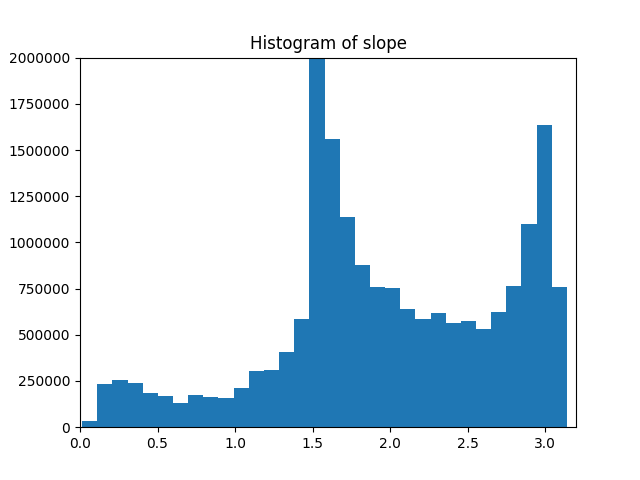

(0, 2000000)

In [43]:
pv_cmap = mpl.colors.ListedColormap(['blue', 'brown', '#ffcc66','#ffffcc'  , '#2eb82e', '#009933' , '#006600', 'black'])
pv_bounds = [0, 1, 1.56, 1.58, 2.5, 3]
pv_norm = mpl.colors.BoundaryNorm(pv_bounds, pv_cmap.N)

fig = plt.figure()
slope.slope.plot.imshow(cmap = pv_cmap, norm = pv_norm, vmin = 0, vmax = 3)

fig = plt.figure()
slope.slope.plot.hist(bins = 32)
plt.xlim([0,3.2])
plt.ylim([0, 2000000])

# Classification

Category | Classifier | Mz

* Water | slope >= 1.56 & slope <= 1.58 & PV <=1 | 1000
* Forest | reflectance_vis <=1300	| 774
* Urban	| BS >=30 & PV >=7 | 806
* Open forest | what's left over |898
* Crops/grassland |PV >=30 & slope >1.58 & slope <=2.5 | 949
* Bare ground | reflectance >=9000 & PV <=50 & PV >=1 | 1063

In [3]:
# Make a dataframe with all of the data in it
all_data = xr.merge([albedo.reflectance, PV.PV, slope.slope, BS.BS, visible.reflectance_vis])
all_data

<xarray.Dataset>
Dimensions:          (x: 7127, y: 5582)
Coordinates:
  * y                (y) float64 -2.376e+06 -2.376e+06 -2.376e+06 -2.376e+06 ...
  * x                (x) float64 1.646e+06 1.646e+06 1.646e+06 1.646e+06 ...
Data variables:
    reflectance      (y, x) float64 8.449e+03 8.578e+03 8.925e+03 8.74e+03 ...
    PV               (y, x) float64 36.0 42.0 43.0 45.0 47.0 46.0 42.0 44.0 ...
    slope            (y, x) float32 1.5708 1.32226 1.53562 1.73392 2.35105 ...
    BS               (y, x) float64 0.0 2.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 3.0 ...
    reflectance_vis  (y, x) float64 2.063e+03 1.936e+03 2.017e+03 1.98e+03 ...

In [4]:
classified = np.empty((len(all_data.y), len(all_data.x)))
classified[:] = np.nan
classified = xr.DataArray(classified, coords = [all_data.y, all_data.x], dims = ['y', 'x'])

In [5]:
# Classify water
x = all_data.slope.where((all_data['slope'] >= 1.56) & (all_data['slope'] <= 1.58) & (all_data['PV'] <= 1))
water = x * 0 + 1000
classified = classified.combine_first(water)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive


In [6]:
# Classify forest
# NB. Forest classification needs to happen after water, or else this condition picks up water too.
#x = all_data.PV.where(all_data['reflectance'] <=6700)
x = all_data.PV.where(all_data['reflectance_vis'] <=1300)
forest = x * 0 + 774
classified = classified.combine_first(forest)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive


In [7]:
# Classify urban
x = all_data.BS.where((all_data['BS'] >= 30) & (all_data['PV'] >= 7))
urban = x * 0 + 806
classified = classified.combine_first(urban)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater_equal
  if not reflexive


In [8]:
# Bare soil
x = all_data.PV.where((all_data['reflectance'] >= 9000) & (all_data['PV'] <= 50) & (all_data['PV'] >=1))
bare = x * 0 + 1063
classified = classified.combine_first(bare)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater_equal
  if not reflexive
/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive


In [9]:
# Classify crops
x = all_data.PV.where((all_data['PV'] >= 30)  
                      & (all_data['slope'] > 1.58) & (all_data['slope'] <= 2.5)) #& (all_data['PV'] < 85)
crops = x * 0 + 949
classified = classified.combine_first(crops)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater_equal
  if not reflexive


### We will assume that everything that has not already been classified is open forest

In [10]:
# Classify open forest
open_forest = all_data.PV * 0 + 898
open_forest
classified = classified.combine_first(open_forest)

# x = all_data.PV.where((all_data['PV'] >= 30) & (all_data['PV'] < 85) & (all_data['reflectance'] >= 9000))

## Plot up the classified dataset

<IPython.core.display.Javascript object>


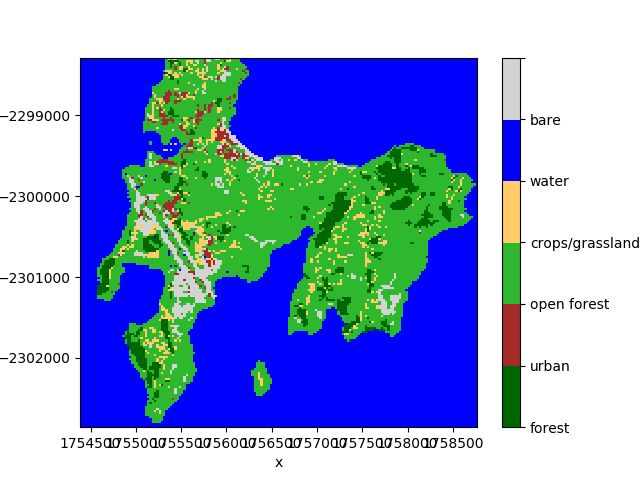

In [11]:
class_cmap = mpl.colors.ListedColormap(['#006600', 'brown', '#2eb82e','#ffcc66' , 'blue', 'lightgrey'])
class_bounds = [774, 806, 898, 949, 1000, 1063, 1064]
class_norm = mpl.colors.BoundaryNorm(class_bounds, class_cmap.N)

fig = plt.figure()
cax = classified.plot.imshow(cmap = class_cmap, norm = class_norm, vmin = 0, vmax = 1064, add_colorbar = False)
cbar = fig.colorbar(cax, ticks= class_bounds)
cbar.ax.set_yticklabels(['forest', 'urban', 'open forest', 'crops/grassland', 'water', 'bare'])

# fig = plt.figure()
# slope.slope.plot.hist(bins = 32)
# plt.xlim([0,3.2])
# plt.ylim([0, 2000000])

# Write out to netcdf

In [53]:
# Convert to dataset so we can name the array variable
classified = classified.to_dataset(name='classified')

# Write out to netcdf
outfile = '/g/data/w85/sj9724/classified_TCDebbie.nc'
classified.to_netcdf(path = outfile, mode = 'w')

# Get the WKT for EPSG:3577 (AGDC projection) 
spatial_ref_object = SpatialReference()
spatial_ref_object.ImportFromEPSG(3577)
spatial_ref = spatial_ref_object.ExportToWkt()

# Add it back into the netcdf file
def fix_crs(nc_path):
    nc_dataset = netCDF4.Dataset(nc_path, 'r+')
    crs = nc_dataset.createVariable('crs', str)
    x = nc_dataset.variables['x']
    y = nc_dataset.variables['y']
    x_pixel_size = float(max(x[:]) - min(x[:])) / (len(x) - 1)
    y_pixel_size = float(min(y[:]) - max(y[:])) / (len(y) - 1) # Negative
    GeoTransform = [min(x[:]) - x_pixel_size / 2.0, x_pixel_size, 0, max(y[:]) + y_pixel_size / 2.0, 0, y_pixel_size]
    crs.spatial_ref = spatial_ref
    crs.GeoTransform = ' '.join([str(n) for n in GeoTransform])
    nc_dataset.close()

fix_crs(outfile)